# Model-based Anomaly Detection

In [ ]:
* 모델기반 이상치 탐지란, 
- 주어진 정상데이터만으로 각 모델들을 학습하여,
- 새로운 데이터가 들어왔을 때 각 모델의 기준에 부합하지 않는 데이터들을 이상치라 판단함.

* 아래의 3가지 모델기반 이상치 탐지기법들을 소개함
1. Auto-Encoder
2. One Class Support Vector Machine(OCSVM)
3. Isolation Forest

## Auto-Encoder

In [ ]:
* 이미지 데이터(예시)를 넣었을 때, 똑같은 이미지를 복원해내는 NN모델
* 이 때, 정상치만을 학습시켜 weight값을 저장하고
* 새로운 이상치가 들어왔을때 복원error값이 높아지므로, 복원이 잘 안될 수록 이상치로 판단

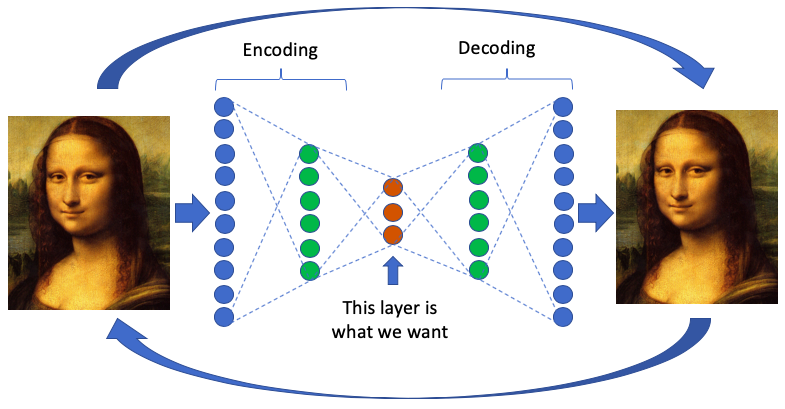

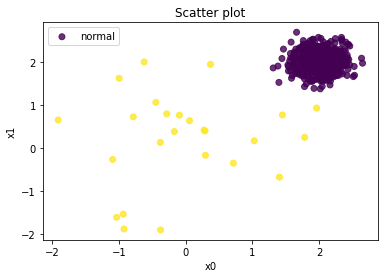

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 25      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

X_train_pd = pd.DataFrame(X_train)
X_train_pd.head()


# Plot # 보라색: 정상치 # 노란색: 이상치
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8,label='normal')
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend(loc='upper left')
plt.show()

In [9]:
from pyod.models.auto_encoder import AutoEncoder
atcdr = AutoEncoder(contamination=0.05, hidden_neurons =[2, 2])
atcdr.fit(X_train)

# Training data
y_train_scores = atcdr.decision_function(X_train)
y_train_pred = atcdr.predict(X_train)

# Test data
y_test_scores = atcdr.decision_function(X_test)
y_test_pred = atcdr.predict(X_test) # outlier labels (0 or 1)

# Threshold for the defined comtanimation rate
print("The threshold for the defined contamination rate:" , atcdr.threshold_)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                650       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 52        
                                                                 
 dropout_2 (Dropout)         (None, 2)                 0         
                                                                 
 dense_3 (Dense)             (None, 2)                 6

Epoch 67/100
15/15 [==============================] - 0s 6ms/step - loss: 1.1254 - val_loss: 1.5443
Epoch 68/100
15/15 [==============================] - 0s 5ms/step - loss: 1.1389 - val_loss: 1.5422
Epoch 69/100
15/15 [==============================] - 0s 6ms/step - loss: 1.1316 - val_loss: 1.5406
Epoch 70/100
15/15 [==============================] - 0s 6ms/step - loss: 1.1343 - val_loss: 1.5387
Epoch 71/100
15/15 [==============================] - 0s 5ms/step - loss: 1.1344 - val_loss: 1.5367
Epoch 72/100
15/15 [==============================] - 0s 5ms/step - loss: 1.1376 - val_loss: 1.5347
Epoch 73/100
15/15 [==============================] - 0s 5ms/step - loss: 1.1257 - val_loss: 1.5324
Epoch 74/100
15/15 [==============================] - 0s 5ms/step - loss: 1.1161 - val_loss: 1.5304
Epoch 75/100
15/15 [==============================] - 0s 5ms/step - loss: 1.1275 - val_loss: 1.5284
Epoch 76/100
15/15 [==============================] - 0s 5ms/step - loss: 1.1091 - val_loss: 1.5264


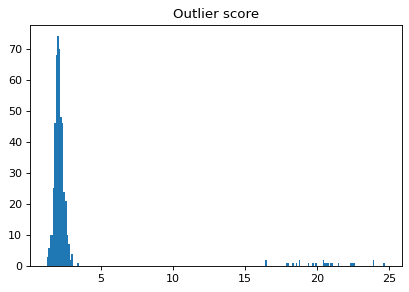

In [10]:
plt.figure(figsize=(6, 4), dpi=80)
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto') # arguments are passed to np.histogram
plt.title("Outlier score")
plt.show()

In [11]:
threshold = atcdr.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,Anomaly_Score
0,Normal,475,95.0,2.01,2.01,2.02,2.00,2.00,2.00,2.0,...,1.99,2.02,2.01,2.00,1.99,2.00,2.0,2.01,1.99,2.12
1,Outlier,25,5.0,-0.02,0.21,-0.05,0.13,0.01,-0.32,0.2,...,-0.07,-0.30,0.11,0.18,0.14,-0.28,0.2,0.09,-0.10,20.37


In [12]:
def confusion_matrix(actual,score, threshold):
    Actual_pred = pd.DataFrame({'Actual': actual, 'Pred': score})
    Actual_pred['Pred'] = np.where(Actual_pred['Pred']<=threshold,0,1)
    cm = pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])
    return (cm)
confusion_matrix(y_train,y_train_scores,threshold)

Pred,0,1
Actual,,
0.0,475,0
1.0,0,25


In [15]:
# Score smoothing
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.auto_encoder import AutoEncoder
atcdr1 = AutoEncoder(contamination=0.05, hidden_neurons =[2, 2])
atcdr2 = AutoEncoder(contamination=0.05, hidden_neurons =[10, 2, 10])
atcdr3 = AutoEncoder(contamination=0.05, hidden_neurons =[15, 10, 2, 10, 15] )

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Just prepare data frames so we can store the model results. There are three models.
train_scores = np.zeros([X_train.shape[0], 3])
test_scores = np.zeros([X_test.shape[0], 3])
atcdr1.fit(X_train_norm)
atcdr2.fit(X_train_norm)
atcdr3.fit(X_train_norm)
    
# Store the results in each column:
train_scores[:, 0] = atcdr1.decision_function(X_train_norm) 
train_scores[:, 1] = atcdr2.decision_function(X_train_norm) 
train_scores[:, 2] = atcdr3.decision_function(X_train_norm)
test_scores[:, 0] = atcdr1.decision_function(X_test_norm) 
test_scores[:, 1] = atcdr2.decision_function(X_test_norm) 
test_scores[:, 2] = atcdr3.decision_function(X_test_norm)

# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 25)                650       
                                                                 
 dropout_4 (Dropout)         (None, 25)                0         
                                                                 
 dense_6 (Dense)             (None, 25)                650       
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 52        
                                                                 
 dropout_6 (Dropout)         (None, 2)                 0         
                                                                 
 dense_8 (Dense)             (None, 2)                

Epoch 67/100
15/15 [==============================] - 0s 6ms/step - loss: 1.2024 - val_loss: 0.9415
Epoch 68/100
15/15 [==============================] - 0s 6ms/step - loss: 1.2003 - val_loss: 0.9388
Epoch 69/100
15/15 [==============================] - 0s 6ms/step - loss: 1.1994 - val_loss: 0.9358
Epoch 70/100
15/15 [==============================] - 0s 6ms/step - loss: 1.1975 - val_loss: 0.9333
Epoch 71/100
15/15 [==============================] - 0s 6ms/step - loss: 1.2036 - val_loss: 0.9310
Epoch 72/100
15/15 [==============================] - 0s 6ms/step - loss: 1.1915 - val_loss: 0.9288
Epoch 73/100
15/15 [==============================] - 0s 6ms/step - loss: 1.1864 - val_loss: 0.9262
Epoch 74/100
15/15 [==============================] - 0s 5ms/step - loss: 1.2010 - val_loss: 0.9238
Epoch 75/100
15/15 [==============================] - 0s 5ms/step - loss: 1.1873 - val_loss: 0.9220
Epoch 76/100
15/15 [==============================] - 0s 14ms/step - loss: 1.1868 - val_loss: 0.9198

 dense_19 (Dense)            (None, 10)                160       
                                                                 
 dropout_16 (Dropout)        (None, 10)                0         
                                                                 
 dense_20 (Dense)            (None, 2)                 22        
                                                                 
 dropout_17 (Dropout)        (None, 2)                 0         
                                                                 
 dense_21 (Dense)            (None, 10)                30        
                                                                 
 dropout_18 (Dropout)        (None, 10)                0         
                                                                 
 dense_22 (Dense)            (None, 15)                165       
                                                                 
 dropout_19 (Dropout)        (None, 15)                0         
          

15/15 [==============================] - 0s 7ms/step - loss: 1.0561 - val_loss: 1.7296
Epoch 70/100
15/15 [==============================] - 0s 7ms/step - loss: 1.0529 - val_loss: 1.7279
Epoch 71/100
15/15 [==============================] - 0s 7ms/step - loss: 1.0544 - val_loss: 1.7249
Epoch 72/100
15/15 [==============================] - 0s 7ms/step - loss: 1.0570 - val_loss: 1.7227
Epoch 73/100
15/15 [==============================] - 0s 8ms/step - loss: 1.0512 - val_loss: 1.7212
Epoch 74/100
15/15 [==============================] - 0s 7ms/step - loss: 1.0513 - val_loss: 1.7191
Epoch 75/100
15/15 [==============================] - 0s 7ms/step - loss: 1.0506 - val_loss: 1.7171
Epoch 76/100
15/15 [==============================] - 0s 7ms/step - loss: 1.0483 - val_loss: 1.7157
Epoch 77/100
15/15 [==============================] - 0s 7ms/step - loss: 1.0492 - val_loss: 1.7141
Epoch 78/100
15/15 [==============================] - 0s 10ms/step - loss: 1.0417 - val_loss: 1.7124
Epoch 79/100

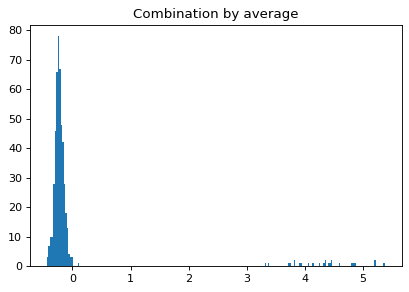

In [16]:
plt.figure(figsize=(6, 4), dpi=80)
# Combination by average
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [17]:
descriptive_stat_threshold(X_train,y_train_by_average, 0.0)

,Group,Count,Count %,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,Anomaly_Score
0,Normal,474,94.8,2.01,2.01,2.03,2.00,2.00,2.00,2.00,...,1.99,2.02,2.01,2.00,1.99,2.00,2.00,2.01,1.99,-0.23
1,Outlier,26,5.2,0.05,0.30,0.01,0.18,0.09,-0.24,0.28,...,0.00,-0.21,0.20,0.25,0.21,-0.18,0.27,0.18,-0.03,4.15


## One Class Support Vector Machine(OCSVM)

In [ ]:
* Threshold(임계치)가 아닌 "boundary"를 사용하여 이상치 여부를 판단함
* OCSVM은 원점으로부터의 거리들을 사용하여 "초평면 boundary"를 만들고, 이를 기준으로 이상치 여부를 판단

(참고)
* SVDD과 OCSVM의 공통점은, 모두 threshold(임계치)가 아닌 boundary를 생성하여 이상치여부를 구분하는 것임
* 차이점은, "boundary의 형태와 중심점"이 다름
* OCSVM에선 초평면을 활용하였다면, SVDD에선 "초구 boundary"를 사용하며 "원점이 중심이 아니어도 무방"함

In [30]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [34]:
# Create an imbalanced dataset
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)
# Convert the data from numpy array to a pandas dataframe
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})
# Check the target distribution
df['target'].value_counts()

0    98970
1     1030
Name: target, dtype: int64

In [43]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the number of records
print('# of training dataset :', X_train.shape[0])
print('# of test dataset :', X_test.shape[0])
print(f"In training set,\n majority class: {sorted(Counter(y_train).items())[0][1]}\n minority class: {sorted(Counter(y_train).items())[1][1]}")

# of training dataset : 80000
# of test dataset : 20000
In training set,
 majority class: 79183
 minority class: 817


In [44]:
# Train the one class support vector machine (SVM) model
one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [45]:
# Predict the anomalies
prediction = one_class_svm.predict(X_test)
# Change the anomalies' values to make it consistent with the true values
prediction = [1 if i==-1 else 0 for i in prediction]
# Check the model performance
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19787
           1       0.06      0.06      0.06       213

    accuracy                           0.98     20000
   macro avg       0.53      0.53      0.53     20000
weighted avg       0.98      0.98      0.98     20000



In [46]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)
# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]
# # Check the prediction performance
print(classification_report(y_test, customized_prediction))

The customized score threshold for 2% of outliers is 182.62
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19787
           1       0.06      0.10      0.07       213

    accuracy                           0.97     20000
   macro avg       0.52      0.54      0.53     20000
weighted avg       0.98      0.97      0.98     20000



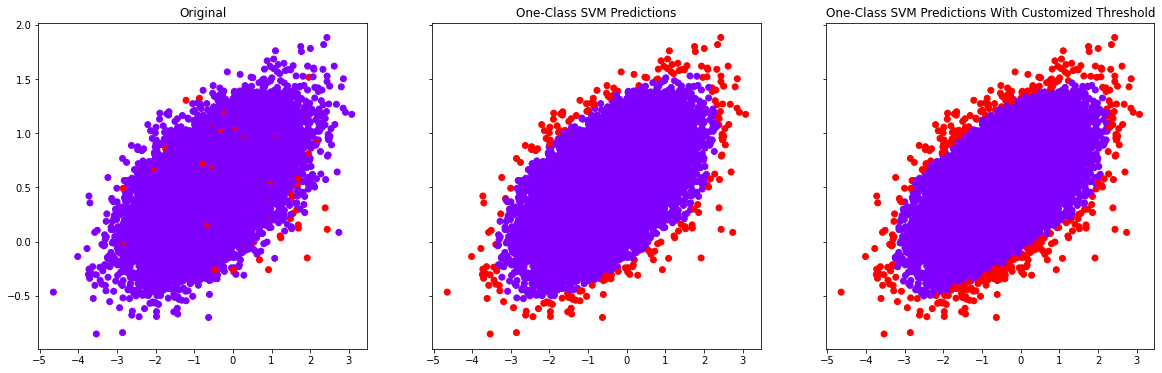

In [47]:
# Put the testing dataset and predictions in the same dataframe
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction
# Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))
# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')

# One-Class SVM Predictions
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')

# One-Class SVM Predictions With Customized Threshold
ax2.set_title('One-Class SVM Predictions With Customized Threshold')
ax2.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow')

## Isolation Forest

In [ ]:
* Forest라는 단어에서 알 수 있듯이, 분기를 하면서 이상치여부를 따지는 tree구조의 모델임
* 이 때, 소수 범주(이상치)는 개체수가 적을 것이므로 적은 분기만으로 고립이 가능하다는 가정
* 따라서, 고립시키는데에 많은 분기가 필요하면 정상, 적은 분기가 필요하다면 이상치데이터로 판단함

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.ensemble import IsolationForest

In [126]:
rng = np.random.RandomState(42)
# Generating training data 
X_train = 0.2 * rng.randn(1000, 2)
X_train = np.r_[X_train + 3, X_train]
X_train = pd.DataFrame(X_train, columns = ['x1', 'x2'])
# Generating new, 'normal' observation
X_test = 0.2 * rng.randn(200, 2)
X_test = np.r_[X_test + 3, X_test]
X_test = pd.DataFrame(X_test, columns = ['x1', 'x2'])
# Generating outliers
X_outliers = rng.uniform(low=-1, high=5, size=(50, 2))
X_outliers = pd.DataFrame(X_outliers, columns = ['x1', 'x2'])

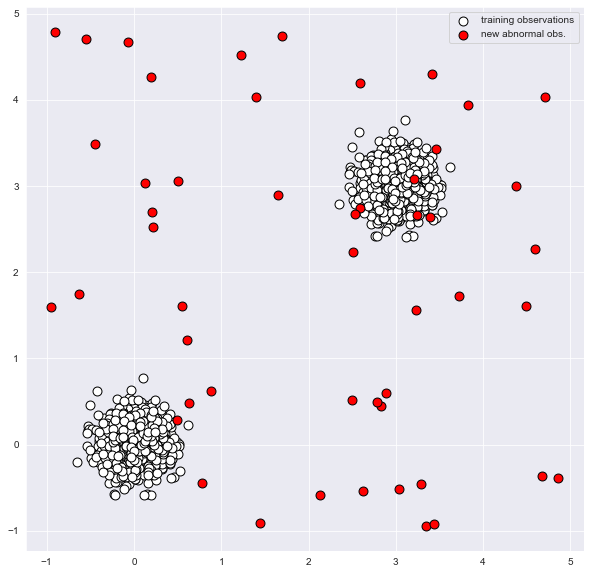

In [127]:
plt.rcParams['figure.figsize'] = [10, 10]
p1 = plt.scatter(X_train.x1, X_train.x2, c='white', s=20*4, edgecolor='k', label='training observations')
# p2 = plt.scatter(X_test.x1, X_test.x2, c='green', s=20*4, edgecolor='k', label='new regular obs.')
p3 = plt.scatter(X_outliers.x1, X_outliers.x2, c='red', s=20*4, edgecolor='k', label='new abnormal obs.')

plt.legend()

In [128]:
clf = IsolationForest(max_samples=100, contamination = 0.1, random_state=42)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

C:\Users\ppuya\anaconda3\envs\jff\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


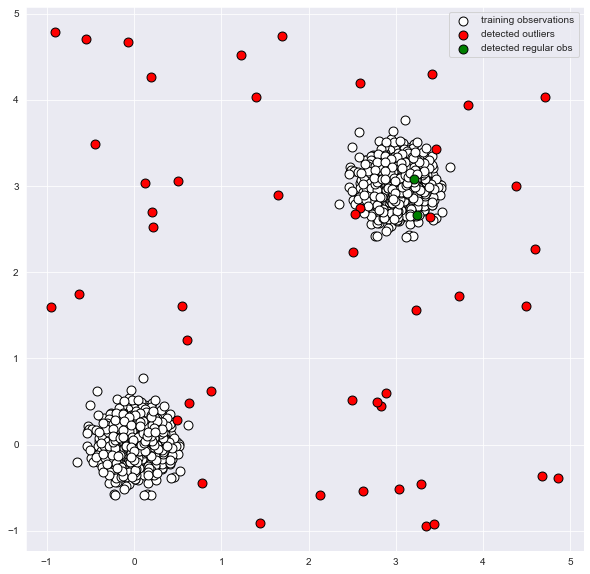

In [130]:
X_outliers = X_outliers.assign(y = y_pred_outliers)
p1 = plt.scatter(X_train.x1, X_train.x2, c='white',
                 s=20*4, edgecolor='k', label="training observations")
p2 = plt.scatter(X_outliers.loc[X_outliers.y == -1, ['x1']], 
                 X_outliers.loc[X_outliers.y == -1, ['x2']], 
                 c='red', s=20*4, edgecolor='k', label="detected outliers")
p3 = plt.scatter(X_outliers.loc[X_outliers.y == 1, ['x1']], 
                 X_outliers.loc[X_outliers.y == 1, ['x2']], 
                 c='green', s=20*4, edgecolor='k', label="detected regular obs")
plt.legend()

In [132]:
# 정확도 수치화
print("Accuracy in test dataset:", list(y_pred_test).count(1)/y_pred_test.shape[0])
print("Accuracy in outlier dataset:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

Accuracy in test dataset: 0.925
Accuracy in outlier dataset: 0.96


### Salary 예제

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
%matplotlib inline

salary = pd.read_csv('../data/jobtitle_pay.csv')
salary.tail()
df = salary.copy()

In [79]:
df = pd.read_csv(r'E:\\coursework\\ba\\2022_BA_donghwanshin/data/Salary_Data.csv')
df = df[['Salary']]
df.head(10)

,Salary
0,39343.0
1,46205.0
2,37731.0
3,43525.0
4,39891.0
5,56642.0
6,60150.0
7,54445.0
8,64445.0
9,57189.0


<AxesSubplot:xlabel='Salary'>

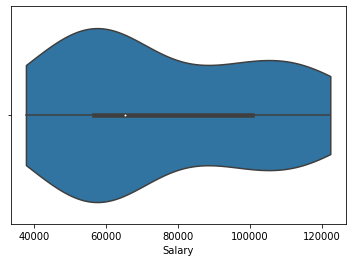

In [124]:
sns.violinplot(data=df['Salary'], x=df['Salary'],cut=0)

In [99]:
# model load #contamination = 이상치의 비율을 뜻함
model=IsolationForest(n_estimators=20, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(df[['Salary']])

C:\Users\ppuya\anaconda3\envs\jff\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.1, n_estimators=20)

In [100]:
df['scores']=model.decision_function(df[['Salary']])
df['anomaly']=model.predict(df[['Salary']])
df

,Salary,scores,anomaly
0,39343.0,0.079769,1
1,46205.0,0.065859,1
2,37731.0,-0.008377,-1
3,43525.0,0.065859,1
4,39891.0,0.073512,1
5,56642.0,0.196694,1
6,60150.0,0.182170,1
7,54445.0,0.128302,1
8,64445.0,0.191647,1
9,57189.0,0.203457,1


In [101]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

      Salary    scores  anomaly
2    37731.0 -0.008377       -1
28  122391.0 -0.024580       -1
29  121872.0 -0.020873       -1


In [95]:
df['Salary']

0      39343.0
1      46205.0
2      37731.0
3      43525.0
4      39891.0
5      56642.0
6      60150.0
7      54445.0
8      64445.0
9      57189.0
10     63218.0
11     55794.0
12     56957.0
13     57081.0
14     61111.0
15     67938.0
16     66029.0
17     83088.0
18     81363.0
19     93940.0
20     91738.0
21     98273.0
22    101302.0
23    113812.0
24    109431.0
25    105582.0
26    116969.0
27    112635.0
28    122391.0
29    121872.0
Name: Salary, dtype: float64

In [118]:
df[(df['Salary'] > 120000) | (df['Salary'] < 38000)]

,Salary,scores,anomaly
2,37731.0,-0.008377,-1
28,122391.0,-0.024580,-1
29,121872.0,-0.020873,-1


In [119]:
outliers_counter = len(df[(df['Salary'] > 120000) | (df['Salary'] < 38000)])
outliers_counter

3

In [120]:
print("Accuracy percentage:", 100*list(df['anomaly']).count(-1)/(outliers_counter),"%")

Accuracy percentage: 100.0 %
